Importing the modules and the classes ML_GRB and RND_FOREST from the ML_GRB.py file.

The class ML_GRB is the main class of the project, while RND_FOREST is the class for the specific model to use in the main class "ML_GRB". The idea is to create other model classes like "RND_FOREST" using similiar structure betwen the model class and the main class (see "ML_GRB.py" for more details).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ML_GRB import ML_GRB, RND_FOREST

Now I intitialize the main class and save it in the variable "GRB". Then I use the function 
DataReading (see functions.py) to read the data from the folder "data". This function takes in 
input the working folder path and saves the data as istances in the class.

Then I use the function DatasetExtrapolation (see function.py) to create, and save in the class, 
the dataset to train the model. 

This dataset has the features [z, DeltaT, alpha_i, beta_i, Ep_i, F_i, 
alpha_p, beta_p, Ep_p, F_p] where i and p stands for TI spectrum and peak spectrum respectively.

Where it wasn't possible to take Band fit it is taken CPL fit imposing beta = -2.5

In [3]:
dir_path = ''       # directory path

GRB = ML_GRB()      # initializing the main class ---> see ML_GRB.py
GRB.DataReading(dir_path)       # reading the data ---> see functions.py

GRB.DatasetExtrapolation()      # creating the dataset ---> see function.py
dataset = GRB.dataset       # saving the dataset in a variable

Here I write a simple implementation of the function CorrMatrix (see functions.py) 
to draw a correlation matrix and to save it in the images folder.

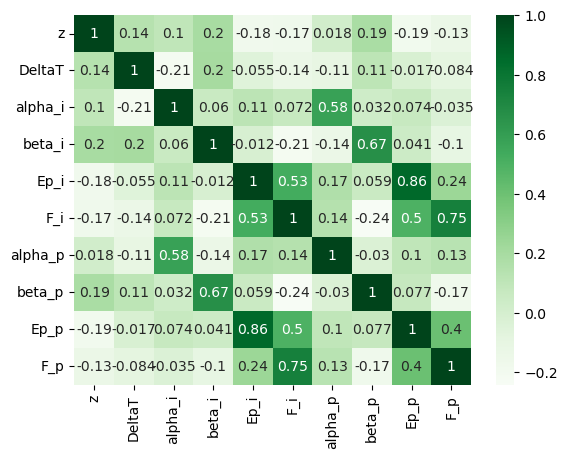

In [4]:
GRB.CorrMatrix(dataset)     # creating a correlation matrix (it can be done prettier in future)
plt.savefig(dir_path + 'images/DatasetCorrMatrix.png')      # saving the image

In the next cell I initialize the model class and save it in the variable "model", then 
I set the model in the main class (see ML_GRB.py). 
After that I train the model with the function Run (see functions.py).

I had set a random_state of 42 to split training and testing data in the same way every time 
I run the code, just to have always the same results.

The hyperparameters n_estimators and max_depth are chosen to be 100 and 7 without specific reason and they have to be tuned with specific methods like GridSearchCV (see the last part of the notebook for more details).

The train_size value is chosen to be 0.8 such that the model can be trained with more data than usual. This is a typical choice for small dataset (standard values for bigger dataset are 0.66 or 0.75).

In [5]:
# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

# Fitting the model ---> see functions.py
GRB.model.Run(dataset, train_size = 0.8, random_state = 3, 
              n_estimators = 100, max_depth = 7)

In the cell below I print the r2 score and the RMSE on the test data and I plot the redshift predicted by the model vs the redshift of the test data

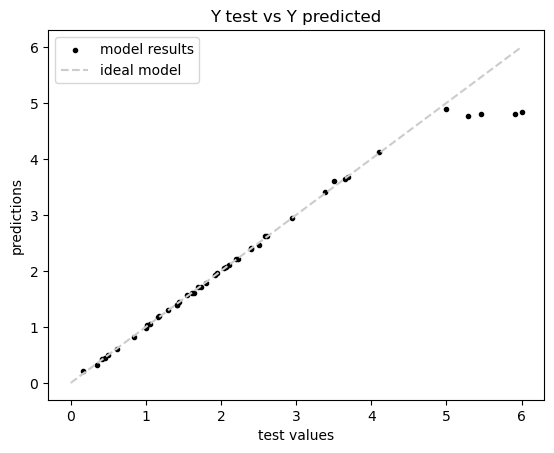

The r2 score is : 0.96669 while the RMSE is: 0.27228


In [6]:
# Importing the RMSE metrics from scikit-learn
from sklearn.metrics import root_mean_squared_error

# Computing the results
test_score = GRB.model.forest.score(GRB.model.X_test, GRB.model.y_test)
rmse = root_mean_squared_error(GRB.model.y_test, GRB.model.y_pred)

# Plotting predictions vs test data
fig, ax = plt.subplots()
ax.set(title = 'Y test vs Y predicted', 
       xlabel = 'test values', 
       ylabel = 'predictions')

ax.scatter(GRB.model.y_test, GRB.model.y_pred, color='k', marker='.', label='model results')

# Plotting a bisector that act as an ideal model
x_values = np.linspace(0, max(GRB.model.y_test), 100)
ax.plot(x_values, x_values, color='0.8', linestyle = '--', label='ideal model')

ax.legend(loc='best')
plt.show()
    
# Printing the results
print('The r2 score is : {:.5f} while the RMSE is: {:.5f}'.format(test_score, rmse))

The results seems really good, but as we discussed in the previous meeting there is a strict dependence between the model performance and the the training/testing data composition, as shown in the next cell where I plot the r2 score of 100 diffrent test/train splits.

Anyway the performance of the model is way better with the dataset features we discussed in the last meeting.

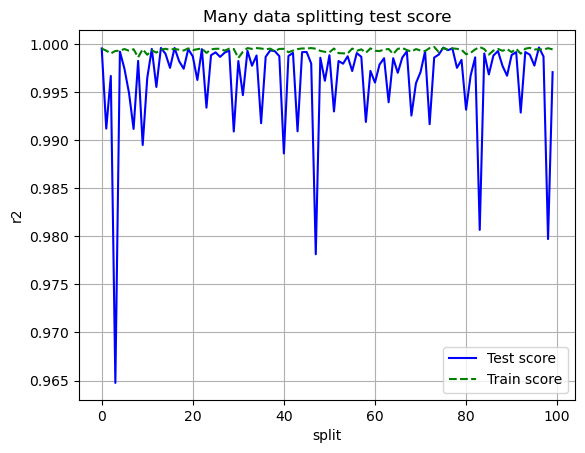

In [7]:
# let's try a loop

# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

# Initializing two list to collect the scores computed in the loop
test_scores = []
train_scores = []
for i in range(100):
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, 
                  n_estimators = 100, max_depth = 7, random_state = i)      # test np.rand for random state

    # Computing the scores
    test_score = GRB.model.forest.score(GRB.model.X_test, GRB.model.y_test)
    train_score = GRB.model.forest.score(GRB.model.X_train, GRB.model.y_train)
    
    test_scores.append(test_score)
    train_scores.append(train_score)
    
# Plotting the train and test r2 score for every train/test split
fig, ax = plt.subplots()
ax.set(
    title = 'Many data splitting test score', 
    xlabel = 'split', 
    ylabel = 'r2'
)
for model, color, style, label in zip([test_scores, train_scores], ['b', 'g'], ['-', '--'], ['Test score', 'Train score']):
    ax.plot(range(len(model)), model, style, color=color, label=label)
ax.grid()
ax.legend(loc='best')
plt.show()

The problem of the plot above could be interpreted as the fact that the redshift distribution is way more dense in the (0, 3) range than it is in the (3, 5) range, so that the training of the model change drastically if the data with [3 < z < 5] are in the training or testing set.

This asymmetric behavour of the redshift distribution can be seen in the histogram below

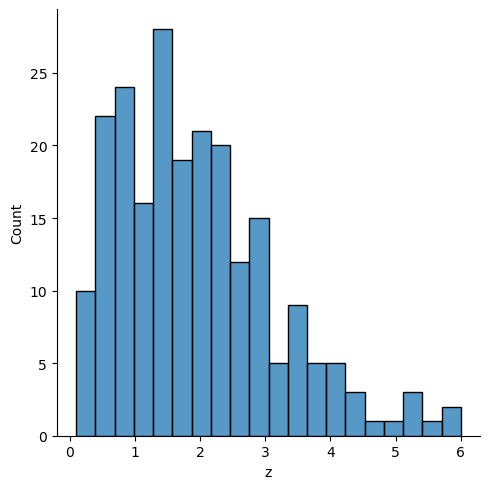

In [8]:
# Displaying the distribution of z

new = ML_GRB()
new.DataReading('')
new.DatasetExtrapolation()
data = new.dataset

sns.displot(data, x = 'z', bins = 20)

To avoid this problem I found in the literature that a standard choice is to use log10(1 + z) instead of z.

The distribution of log10(1 + z) can be seen below

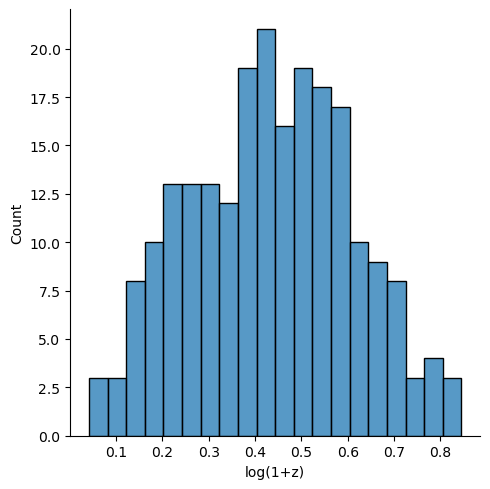

In [9]:
# Displaying the distribution of log10(1 + z)

data['z'] = np.log10(1 + data['z'])
data = data.rename(columns={'z': 'log(1+z)'})

sns.displot(data, x = 'log(1+z)', bins = 20)

In the next cell I plot a comparison between the r2 score obtained training the model with z and the r2 score obtained training the model with log10(1 + z).

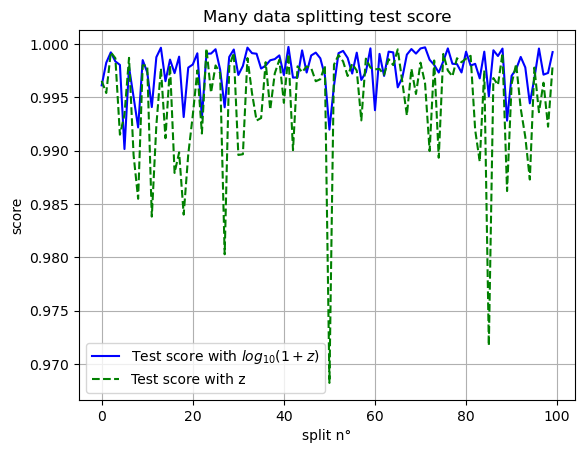

In [13]:
GRB = ML_GRB()
GRB.DataReading('')
GRB.DatasetExtrapolation()

dataset = GRB.dataset

model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

random_seeds = np.random.randint(1000, size=100)

test_scores = []
test_scores_log = []
for i in random_seeds:
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, 
                  n_estimators = 10, max_depth = 7, random_state = i)

    test_score = GRB.model.forest.score(GRB.model.X_test, GRB.model.y_test)
    
    test_scores.append(test_score)
    
dataset['z'] = np.log10(1 + dataset['z'])
for i in random_seeds:
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, 
                  n_estimators = 100, max_depth = 7, random_state = i)

    test_score_log = GRB.model.forest.score(GRB.model.X_test, GRB.model.y_test)    
    
    
    test_scores_log.append(test_score_log)
    
fig, ax = plt.subplots()
ax.set(
    title = 'Many data splitting test score', 
    xlabel = 'split n°', 
    ylabel = 'score'
)
for model, color, style, label in zip([test_scores_log, test_scores], ['b', 'g'], ['-', '--'], ['Test score with $log_{10}(1 + z)$', 'Test score with z']):
    ax.plot(range(len(model)), model, style, color=color, label=label)
ax.grid()
ax.legend(loc='best')
plt.show()

The r2 score is not always the best metric to evaluate a regression model because it doesn't return an estimation of the possible overfitting behavour of the model.

A better metrics for this porpouse is the RMSE (root mean squared error).
In the next cell I plot the RMSE for 100 different test/train splits for a model trained with z and a model trained with log10(1 + z).

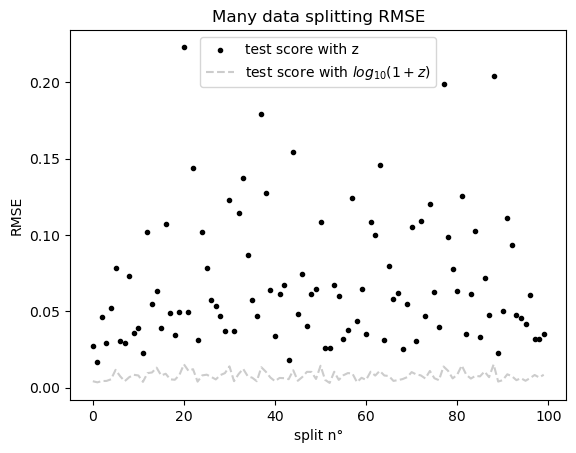

In [14]:
GRB = ML_GRB()
GRB.DataReading('')
GRB.DatasetExtrapolation()

dataset = GRB.dataset

# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

random_seeds = np.random.randint(1000, size=100)

test_scores = []
test_scores_log = []
for i in random_seeds:
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, 
                  n_estimators = 100, max_depth = 8, random_state = i)
    
    test_scores.append(root_mean_squared_error(GRB.model.y_test, GRB.model.y_pred))

dataset['z'] = np.log10(1 + dataset['z'])
for i in random_seeds:
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, 
                  n_estimators = 100, max_depth = 8, random_state = i)

    test_scores_log.append(root_mean_squared_error(GRB.model.y_test, GRB.model.y_pred))
    
fig, ax = plt.subplots()
ax.set(
    title = 'Many data splitting RMSE', 
    xlabel = 'split n°', 
    ylabel = 'RMSE'
)
ax.scatter(range(len(test_scores)), test_scores, marker='.', color='k', label='test score with z')
ax.plot(range(len(test_scores_log)), test_scores_log, linestyle='--', color='0.8', label='test score with $log_{10}(1 + z)$')
ax.legend(loc='best')
plt.show()

Although the results seems incredible I returned to the sad reality when I considered to reconvert the redshift after the training of the model and used the r2 and the RMSE to evaluate the performance of the model in predicting the reconverted redshift. 

The results are shown in the next 2 cells.

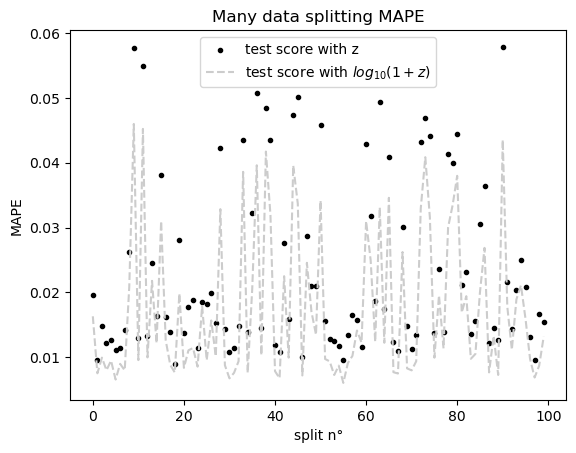

In [18]:
from sklearn.metrics import mean_absolute_percentage_error

GRB = ML_GRB()
GRB.DataReading('')
GRB.DatasetExtrapolation()

dataset = GRB.dataset

# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

random_seeds = np.random.randint(1000, size=100)

test_scores = []
test_scores_log = []
for i in random_seeds:
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, 
                  n_estimators = 100, max_depth = 8, random_state = i)
    
    test_scores.append(mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred))

dataset['z'] = np.log10(1 + dataset['z'])
for i in random_seeds:
    # Fitting the model ---> see functions.py
    GRB.model.Run(dataset, train_size = 0.8, 
                  n_estimators = 100, max_depth = 8, random_state = i)

    # z_test_list = []
    # z_pred_list = []
    # for test, pred in zip(GRB.model.y_test, GRB.model.y_pred):
    #        z_test = 10**test - 1
    #        z_pred = 10**pred - 1

    #        z_test_list.append(z_test)
    #        z_pred_list.append(z_pred)


    # test_scores_log.append(mean_absolute_percentage_error(z_test_list, z_pred_list))
    test_scores_log.append(mean_absolute_percentage_error(GRB.model.y_test, GRB.model.y_pred))
    
fig, ax = plt.subplots()
ax.set(
    title = 'Many data splitting MAPE', 
    xlabel = 'split n°', 
    ylabel = 'MAPE'
)
ax.scatter(range(len(test_scores)), test_scores, marker='.', color='k', label='test score with z')
ax.plot(range(len(test_scores_log)), test_scores_log, linestyle='--', color='0.8', label='test score with $log_{10}(1 + z)$')
ax.legend(loc='best')
plt.show()

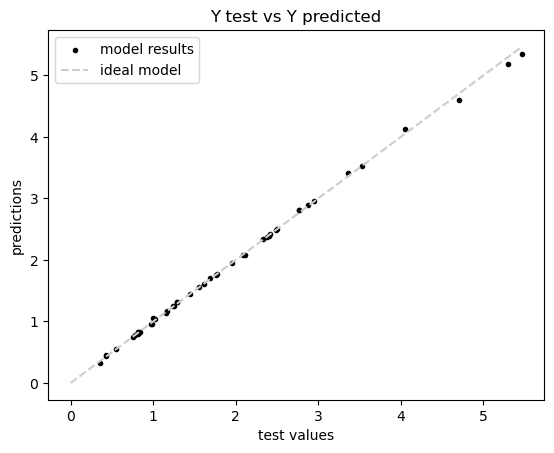

The test score is : 0.99920 while the RMSE is: 0.03512


In [16]:
from sklearn.metrics import r2_score, root_mean_squared_error

GRB = ML_GRB()
GRB.DataReading('')
GRB.DatasetExtrapolation()

dataset = GRB.dataset

dataset['z'] = np.log10(1 + dataset['z'])

# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

# Fitting the model ---> see functions.py
GRB.model.Run(dataset, train_size = 0.8, random_state = 42, 
              n_estimators = 100, max_depth = 7)

z_test_list = []
z_pred_list = []
for test, pred in zip(GRB.model.y_test, GRB.model.y_pred):
       z_test = 10**test - 1
       z_pred = 10**pred - 1
       
       z_test_list.append(z_test)
       z_pred_list.append(z_pred)

# Printing the results
test_score = r2_score(z_test_list, z_pred_list)
rmse = root_mean_squared_error(z_test_list, z_pred_list)

fig, ax = plt.subplots()
ax.set(title = 'Y test vs Y predicted', 
       xlabel = 'observed z', 
       ylabel = 'predictions')

ax.scatter(z_test_list, z_pred_list, color='k', marker='.', label='model results')

x_values = np.linspace(0, max(z_test_list), 100)
ax.plot(x_values, x_values, color='0.8', linestyle = '--', label='ideal model')

ax.legend(loc='best')
plt.show()

print('The test score is : {:.5f} while the RMSE is: {:.5f}'.format(test_score, rmse))

Anyway the conversion of z to log10(1 + z) could be useful to evaluate the model performance in order to tuned the best hyperparameters combination.

In the next cells it is used a Grid Search Cross Validation method tu evaluate the best value for the hyperparameter "max depth" using the RMSE score (The best hyperparameter is chosen such that the value of the standard deviation of the RMSE is minimum instead of minimize the RMSE itself)

In [ ]:
# trying grid search

# Let's try

import numpy as np
from sklearn.metrics import mean_squared_error

# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class

dataset['z'] = np.log10(1 + dataset['z'])

# Setting the hyperparameters space to investigate
grid = {
        'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
        'rf__n_jobs': [-1]
    }

# Running the Grid Search 
GRB.model.GridSearch(dataset, grid, cv = 10, train_size = 0.8, scoring = 'neg_median_absolute_error')

results = pd.DataFrame(GRB.model.Grid_search_class.cv_results_)

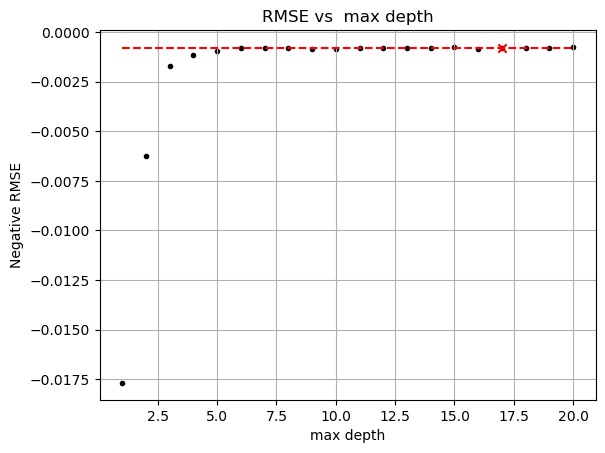

In [ ]:
a = results[['std_test_score']].to_numpy()
min_a = min(a)
index = np.where(a == min_a)

x = results['param_rf__max_depth'].to_numpy()
y = results['mean_test_score'].to_numpy()

X = x[index[0]]
Y = y[index[0]]

fig, ax = plt.subplots()
ax.set(title = 'RMSE vs  max depth', 
       xlabel = 'max depth', 
       ylabel = 'Negative RMSE')
ax.scatter(x, y, marker='.', color='k')
ax.scatter(X, Y, marker='x', color='r')
ax.plot(np.linspace(x[0], x[-1], 100), np.full(100, Y), linestyle='--', color='r')
ax.grid()
plt.show()

It is better to do a loop where the Grid Search Cross Validation function runs multiple times to a better consistency of this method. 

I do this in the next cell and I plot an histogram of the best max depth found in every cycle.

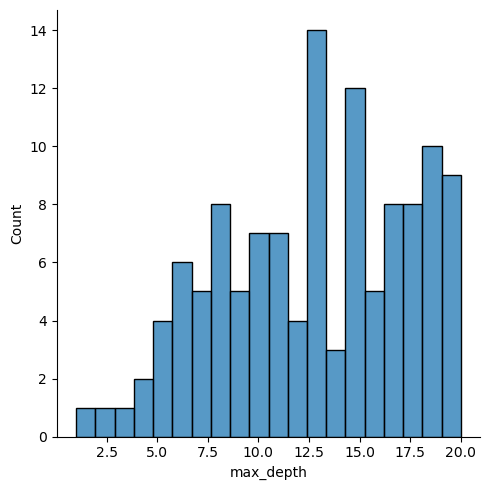

In [ ]:
# Inizialising the model class ---> see ML_GRB.py
model = RND_FOREST()
GRB.SetModel(model)     # Setting the model in the main class
dataset['z'] = np.log10(1 + dataset['z'])

# Setting the hyperparameters space to investigate
grid = {
        'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
        'rf__n_jobs': [-1]
    }

hyperparameters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for i in range(100):    
    # Running the Grid Search 
    GRB.model.GridSearch(dataset, grid, cv = 10, train_size = 0.8, scoring = 'neg_median_absolute_error')

    results = pd.DataFrame(GRB.model.Grid_search_class.cv_results_)
    
    a = results[['std_test_score']].to_numpy()
    min_a = min(a)
    index = np.where(a == min_a)

    hp = results['param_rf__max_depth'].to_numpy()
    
    best_hp = hp[index[0]]

    hyperparameters.append(best_hp[0])

max_depth = pd.DataFrame({'max_depth': hyperparameters})

sns.displot(max_depth, x = 'max_depth', bins = len(hp))

In the next cell I was just testing a better way to visualize the correlation matrix of the dataset

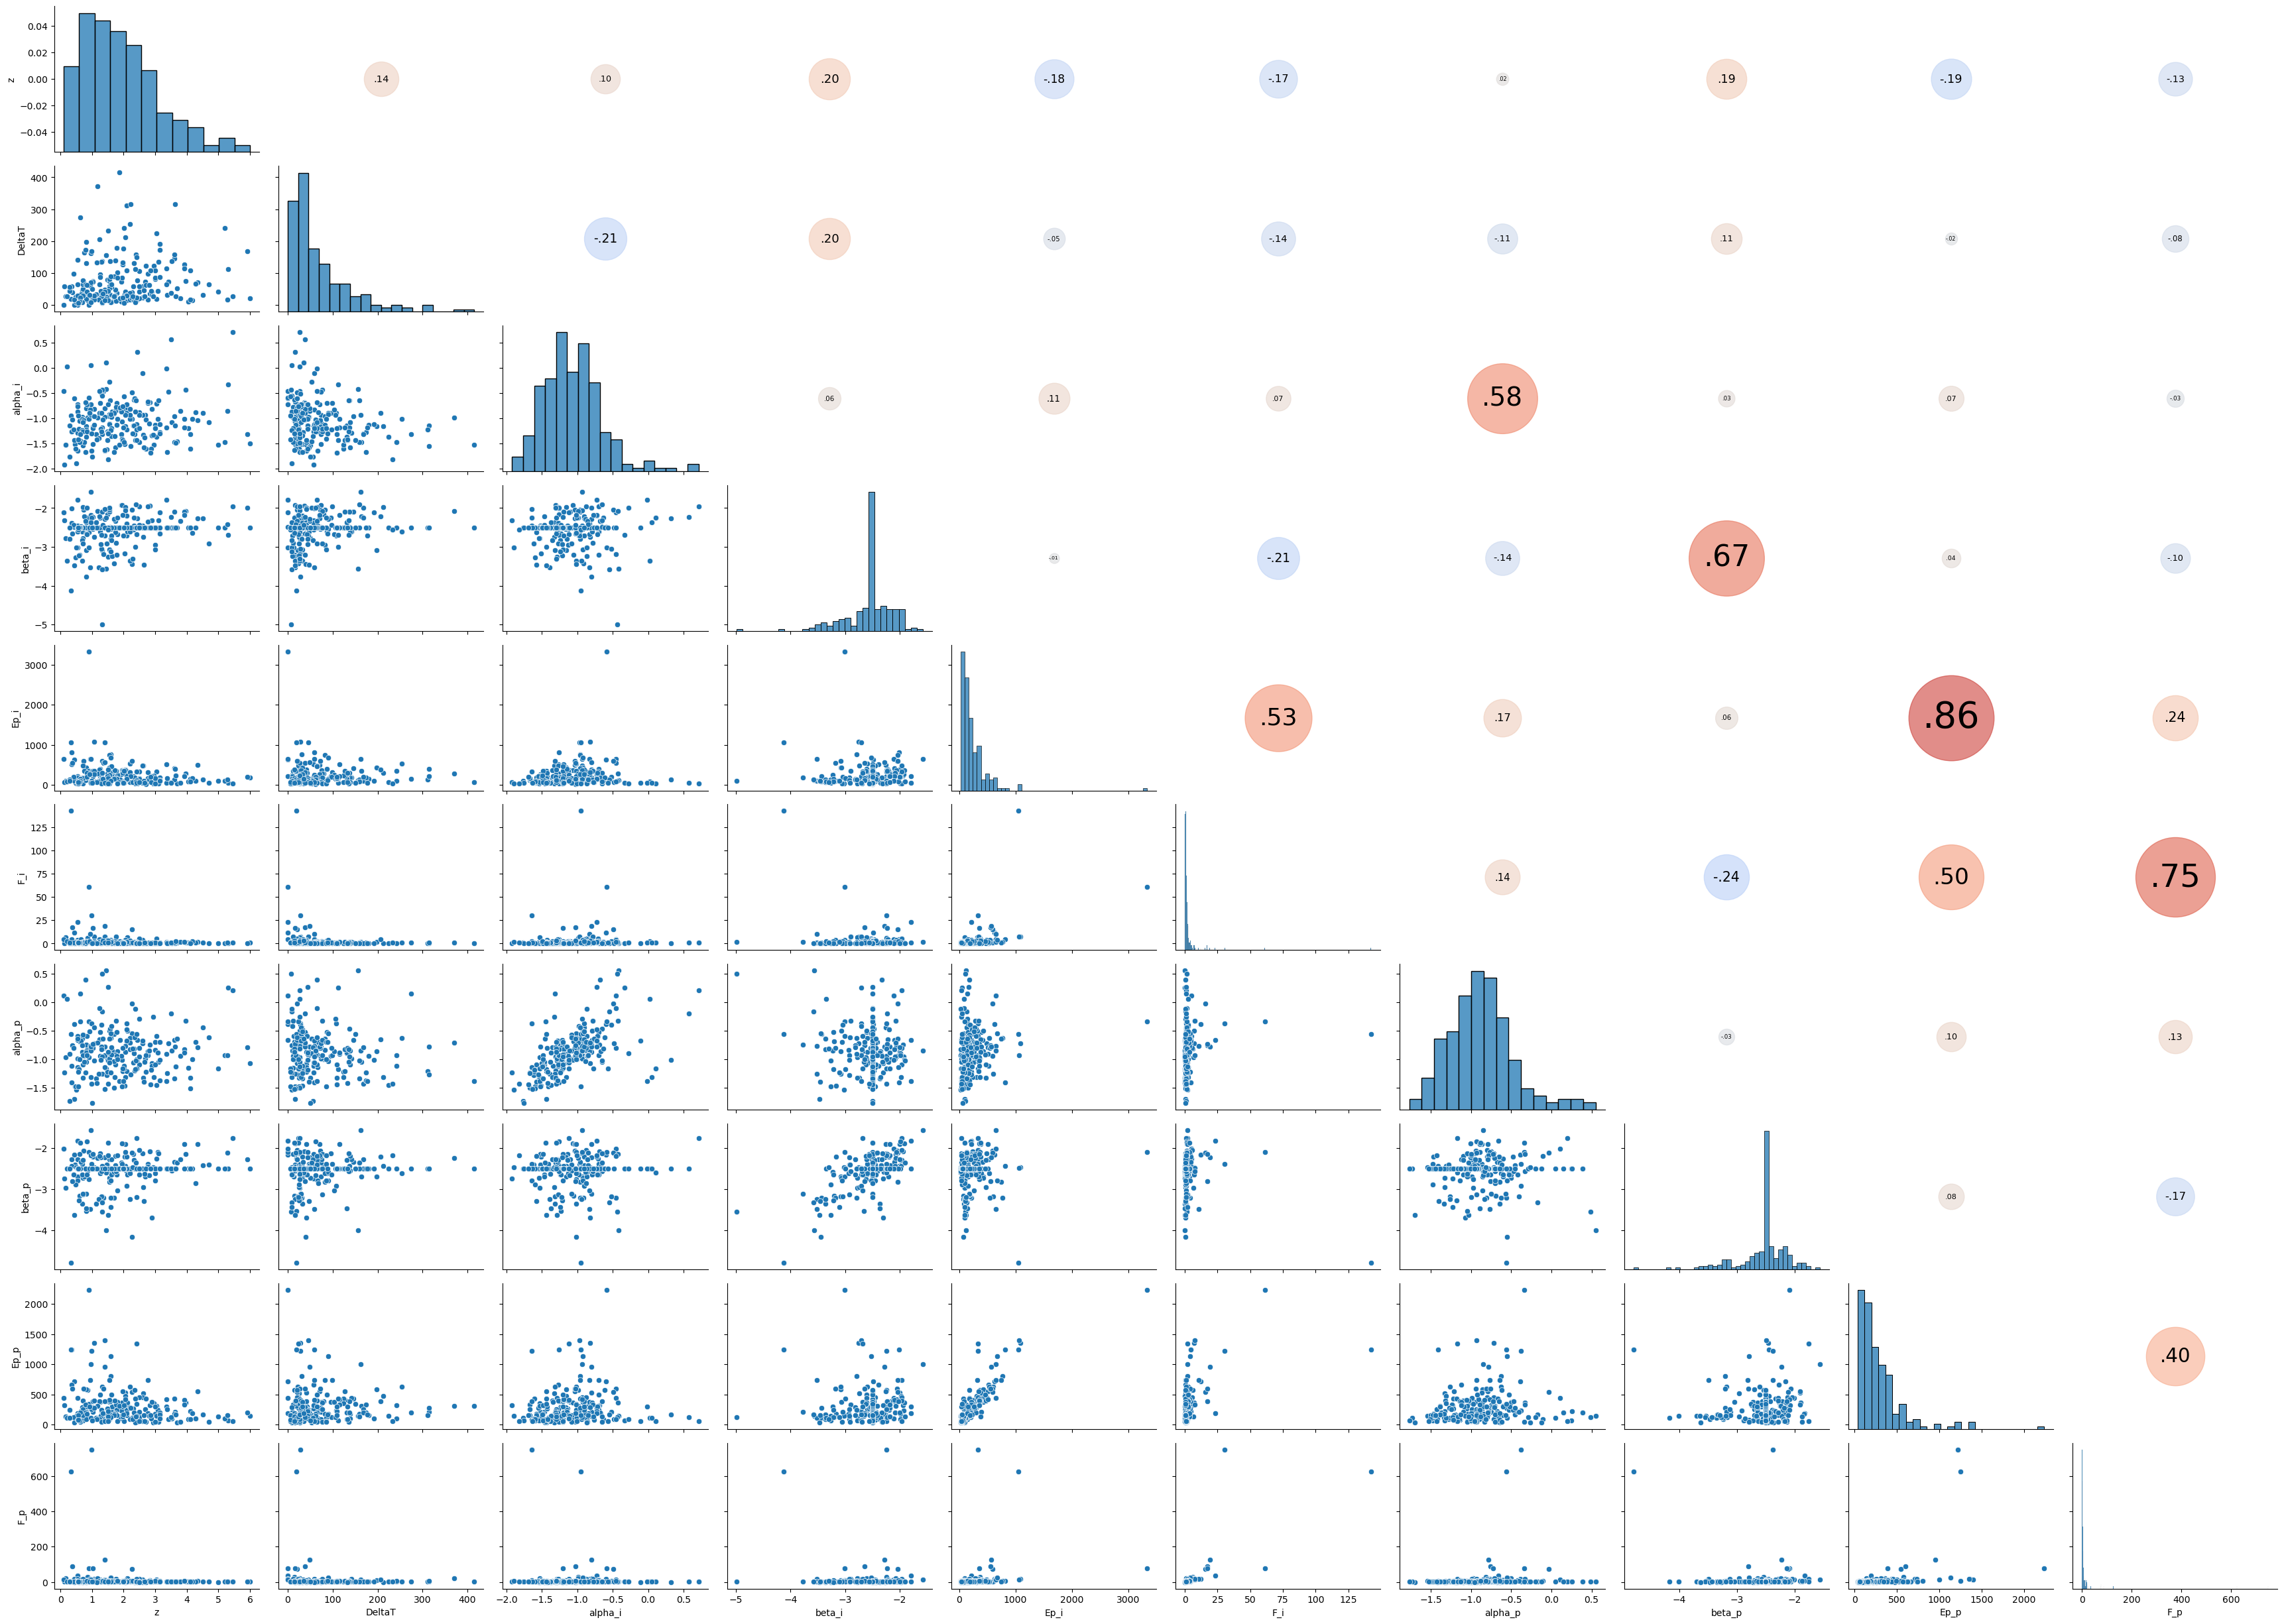

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

new = ML_GRB()
new.DataReading('')
new.DatasetExtrapolation()
data = new.dataset

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm", vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5], xycoords="axes fraction", ha='center', va='center', fontsize=font_size)

g = sns.PairGrid(data, aspect=1.4, diag_sharey=False)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.map_upper(corrdot)
plt.show()